In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [216]:
df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [217]:
df['week'] = df['time_stamp'].dt.week
df = df.groupby(['week','user_id'])['time_stamp'].count().reset_index(name="freq")

result = df[df.freq >= 3]

user_ids = result.user_id.tolist()
user_ids

C:\Users\Andrew\AppData\Local\Temp\ipykernel_18752\4198980684.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['time_stamp'].dt.week


[10,
 42,
 63,
 69,
 81,
 82,
 87,
 146,
 153,
 160,
 168,
 197,
 202,
 203,
 209,
 230,
 245,
 263,
 297,
 310,
 322,
 445,
 471,
 483,
 509,
 510,
 529,
 535,
 553,
 564,
 603,
 605,
 639,
 669,
 679,
 680,
 724,
 728,
 754,
 772,
 783,
 804,
 845,
 882,
 885,
 901,
 906,
 912,
 934,
 937,
 943,
 980,
 1017,
 1018,
 1027,
 1055,
 1061,
 1072,
 1094,
 1099,
 1128,
 1129,
 1155,
 1196,
 1202,
 1280,
 1320,
 1339,
 1343,
 1345,
 1350,
 1357,
 1368,
 1407,
 1411,
 1421,
 1434,
 1464,
 1472,
 1476,
 1479,
 1485,
 1507,
 1576,
 1617,
 1624,
 1665,
 1693,
 1709,
 1730,
 1754,
 1769,
 1781,
 1783,
 1786,
 1811,
 1821,
 1822,
 1836,
 1865,
 1879,
 1885,
 1941,
 2002,
 2011,
 2013,
 2033,
 2042,
 2074,
 2078,
 2080,
 2103,
 2113,
 2159,
 2171,
 2193,
 2246,
 2253,
 2270,
 2271,
 2286,
 2289,
 2300,
 2316,
 2324,
 2333,
 2339,
 2390,
 2406,
 2425,
 2447,
 2474,
 2490,
 2502,
 2519,
 2539,
 2548,
 2557,
 2566,
 2568,
 2571,
 2604,
 2620,
 2622,
 2647,
 2658,
 2672,
 2723,
 2727,
 2739,
 2744,
 2

In [218]:
df = pd.read_csv('takehome_users.csv', encoding_errors='ignore')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [219]:
df['engaged'] = np.where(df['object_id'].isin(user_ids), 1, 0)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [220]:
df = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'engaged']]
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


In [221]:
df = pd.get_dummies(df, prefix='creation_source', columns=['creation_source'])
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,1,0,0,0,0
1,0,0,1,1,0,1,0,0,0
2,0,0,94,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0
4,0,0,193,0,1,0,0,0,0


In [222]:
models = {"Logistic": LogisticRegression(), "RForest": RandomForestClassifier(), "XGBoost": xgb.XGBClassifier()}

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['engaged']), df.engaged, test_size=0.25, random_state=47)

results = []

for model in models.values():

    pipe = make_pipeline(
        model
    )

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf)

    results.append(cv_scores)

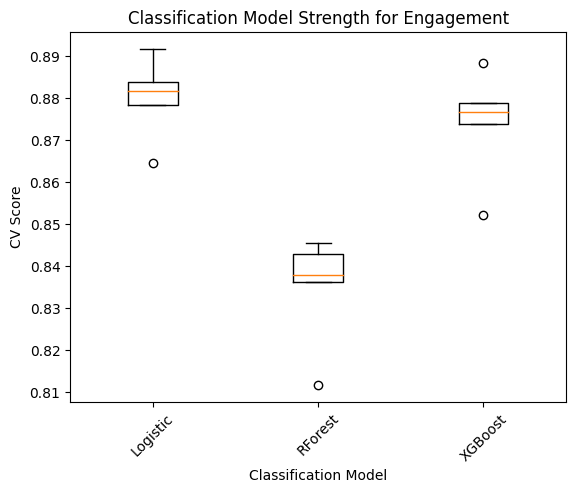

In [223]:
plt.boxplot(results, labels=models.keys())
plt.title("Classification Model Strength for Engagement")
plt.ylabel("CV Score")
plt.xlabel("Classification Model")
plt.xticks(rotation=45)
plt.show()

In [224]:
xgbmodel = xgb.XGBClassifier()

grid_params = {
    'learning_rate' : (0.05, 0.10, 0.15, 0.2, 0.25, 0.3),
    'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

xgb_grid_cv = GridSearchCV(xgbmodel, param_grid=grid_params, cv=5, n_jobs=-1)
xgb_grid_cv.fit(X_train, y_train)
print(xgb_grid_cv.best_params_)

{'learning_rate': 0.05, 'n_estimators': 100}


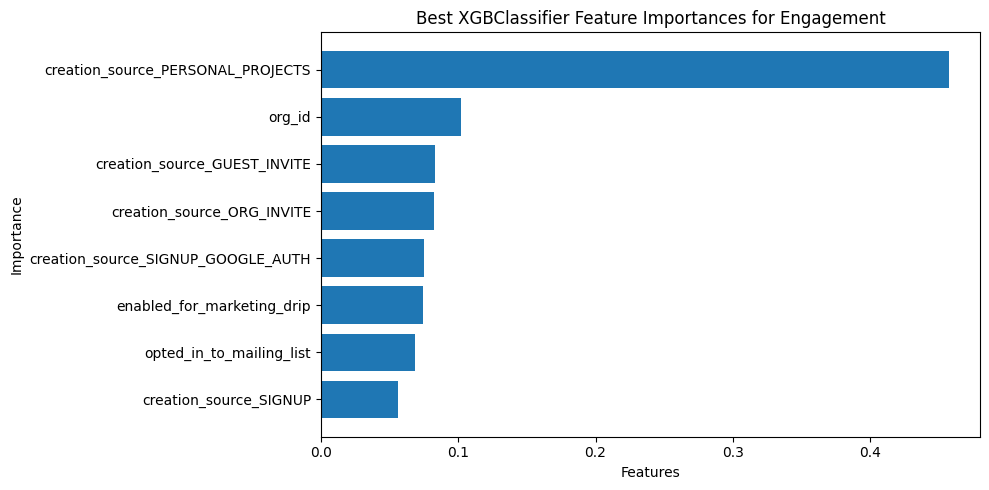

In [225]:
sorted_index = xgb_grid_cv.best_estimator_.feature_importances_.argsort()

plt.subplots(figsize=(10, 5))
plt.barh(X_train.columns[sorted_index], xgb_grid_cv.best_estimator_.feature_importances_[sorted_index])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best XGBClassifier Feature Importances for Engagement')
plt.tight_layout()

In [235]:
print('CS Personal Projects : ' + str(df['engaged'].corr(df['creation_source_PERSONAL_PROJECTS'])))
print('CS Guest Invite : ' + str(df['engaged'].corr(df['creation_source_GUEST_INVITE'])))
print('CS Org Invite : ' + str(df['engaged'].corr(df['creation_source_ORG_INVITE'])))
print('CS Signup : ' + str(df['engaged'].corr(df['creation_source_SIGNUP'])))
print('CS Signup Google Authentication : ' + str(df['engaged'].corr(df['creation_source_SIGNUP_GOOGLE_AUTH'])))
print('Opted Into Mailing List : ' + str(df['engaged'].corr(df['opted_in_to_mailing_list'])))
print('Enabled For Marketing Drip : ' + str(df['engaged'].corr(df['enabled_for_marketing_drip'])))
print('Org ID : ' + str(df['engaged'].corr(df['org_id'])))

CS Personal Projects : -0.07209265102695622
CS Guest Invite : 0.04365728885273945
CS Org Invite : -0.011376030281460423
CS Signup : 0.016003947764581968
CS Signup Google Authentication : 0.03143208592027584
Opted Into Mailing List : 0.010339067805264338
Enabled For Marketing Drip : 0.0059006291320358025
Org ID : 0.060682576648155344
